# Basic setup

## preprocessing

In [2]:
#!pip install datasets transformers scikit-learn

In [2]:
import json
import pandas as pd
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

train_files = [
    "../data/eng-danc.json",
    "../data/eng-fina.json",
    "../data/eng-nava.json",
    "../data/eng-redh.json",
    "../data/eng-scan.json",
    "../data/eng-spec.json"
]
    
test_file = "../data/eng-houn.json"

In [6]:
def extract_words_and_sentiments(data):
    """
    Transforms a JSON data object into a list of [words, sentiment_labels] pairs.
    Sentiment is assigned to tokens based on the 'wids' from the concept data.
    Tokens not associated with any concept get a sentiment of 0.
    """
    transformed_data = []

    for sentence in data.get("sentences", []):
        words = sentence.get("words", [])
        concepts = sentence.get("concepts", [])

        word_list = [w["word"] for w in words]
        sentiment_list = ["NEUTRAL"] * len(words)  # initialize all sentiments as neutral (0)

        # map word id to index in words list
        wid_to_index = {w["wid"]: idx for idx, w in enumerate(words)}

        for concept in concepts:
            if "sentiment" in concept and "wids" in concept:
                sentiment = concept["sentiment"]

                if sentiment <= -20:
                    simple_sentiment = "NEGATIVE"
                elif sentiment >= 20:
                    simple_sentiment = "POSITIVE"
                else:
                    simple_sentiment = "NEUTRAL"

                for wid in concept["wids"]:
                    idx = wid_to_index.get(wid)
                    if idx is not None:
                        sentiment_list[idx] = simple_sentiment

        transformed_data.append([word_list, sentiment_list])

    return transformed_data


In [8]:
combined_train_list = []

for file in train_files:
    with open(file, "r") as f:
        data = json.load(f)
        transformed = extract_words_and_sentiments(data)
        combined_train_list.extend(transformed)

In [10]:
with open(test_file, "r") as f:
    test_data = json.load(f)
    
test_list = extract_words_and_sentiments(test_data)
combined_train_list[0]

[['The', 'Adventure', 'of', 'the', 'Dancing', 'Men'],
 ['NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL']]

In [12]:
df_train = pd.DataFrame(combined_train_list, columns=['tokens', 'sentiment_label'])
df_test = pd.DataFrame(test_list, columns=['tokens', 'sentiment_label'])
print(df_train.head())

                                              tokens  \
0            [The, Adventure, of, the, Dancing, Men]   
1  [Holmes, had, been, seated, for, some, hours, ...   
2  [His, head, was, sunk, upon, his, breast, ,, a...   
3  [", So, ,, Watson, ,, ", said, he, ,, suddenly...   
4           [I, gave, a, start, of, astonishment, .]   

                                     sentiment_label  
0  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
1  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
2  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
3  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
4  [NEUTRAL, NEUTRAL, NEUTRAL, NEGATIVE, NEUTRAL,...  


In [14]:
label_map = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}

df_train["sentiment_label"] = df_train["sentiment_label"].apply(
    lambda labels: [label_map[label] for label in labels]
)
df_test["sentiment_label"] = df_test["sentiment_label"].apply(
    lambda labels: [label_map[label] for label in labels]
)


In [16]:
dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)
print(dataset_train[3])

{'tokens': ['"', 'So', ',', 'Watson', ',', '"', 'said', 'he', ',', 'suddenly', ',', '"', 'you', 'do', 'not', 'propose', 'to', 'invest', 'in', 'South', 'African', 'securities', '?', '"'], 'sentiment_label': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1]}


In [18]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [20]:
label_all_tokens = True

In [22]:
def tokenize_and_align_labels(dataset, label_all_tokens=True):
    tokenized_inputs = tokenizer(dataset["tokens"], truncation=True, is_split_into_words=True)

    sentiment_results = []
    attention_masks = []
    word_ids_results = []

    for i, sentiment_labels in enumerate(dataset["sentiment_label"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None

        token_sentiments = []
        attention_mask = []
        word_ids_tokens = []

        for word_idx, input_id in zip(word_ids, tokenized_inputs["input_ids"][i]):
            word_ids_tokens.append(word_idx)

            if word_idx is None:
                token_sentiments.append(-100)
                attention_mask.append(0)
            elif word_idx != previous_word_idx:
                token_sentiments.append(sentiment_labels[word_idx])
                attention_mask.append(1)
            else:
                token_sentiments.append(sentiment_labels[word_idx] if label_all_tokens else -100)
                attention_mask.append(1)

            previous_word_idx = word_idx

        sentiment_results.append(token_sentiments)
        attention_masks.append(attention_mask)
        word_ids_results.append(word_ids_tokens)

    tokenized_inputs["labels"] = sentiment_results
    tokenized_inputs["attention_mask"] = attention_masks
    tokenized_inputs["word_ids"] = word_ids_results

    return tokenized_inputs


In [24]:
tokenize_and_align_labels(dataset_train[:3])

{'input_ids': [[101, 1996, 6172, 1997, 1996, 5613, 2273, 102], [101, 9106, 2018, 2042, 8901, 2005, 2070, 2847, 1999, 4223, 2007, 2010, 2146, 1010, 4857, 2067, 9203, 2058, 1037, 5072, 6258, 1999, 2029, 2002, 2001, 16005, 1037, 3391, 15451, 7716, 25373, 4031, 1012, 102], [101, 2010, 2132, 2001, 10417, 2588, 2010, 7388, 1010, 1998, 2002, 2246, 2013, 2026, 2391, 1997, 3193, 2066, 1037, 4326, 1010, 17595, 2243, 4743, 1010, 2007, 10634, 3897, 28764, 1998, 1037, 2304, 2327, 1011, 12226, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[0, 1, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [26]:
tokenized_training_dataset = dataset_train.map(tokenize_and_align_labels, batched=True)
tokenized_test_dataset = dataset_test.map(tokenize_and_align_labels, batched=True)

Map:   0%|                                      | 0/3651 [00:00<?, ? examples/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|████████████████████████| 3824/3824 [00:00<00:00, 12260.31 examples/s]


In [27]:
tokenized_training_dataset[0]

{'tokens': ['The', 'Adventure', 'of', 'the', 'Dancing', 'Men'],
 'sentiment_label': [1, 1, 1, 1, 1, 1],
 'input_ids': [101, 1996, 6172, 1997, 1996, 5613, 2273, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [0, 1, 1, 1, 1, 1, 1, 0],
 'labels': [-100, 1, 1, 1, 1, 1, 1, -100],
 'word_ids': [None, 0, 1, 2, 3, 4, 5, None]}

## model training

In [32]:
#!pip install evaluate
#!pip install seqeval
#!pip install torch
#!pip install "accelerate>=0.26.0"

In [32]:
import evaluate
import numpy as np
model_checkpoint = "bert-base-uncased"
task = "sentiment_analysis"
batch_size = 16

In [34]:
from transformers import set_seed

#put your seed
SEED = 4
set_seed(SEED)
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

In [36]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load("seqeval")
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
label_list = ["NEGATIVE", "NEUTRAL", "POSITIVE"]

In [38]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [42]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_training_dataset,
    eval_dataset=tokenized_test_dataset, #write test
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_1924/4074046499.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [44]:
trainer.train()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.091678,0.363555,0.474027,0.411506,0.937853
2,No log,0.064093,0.495367,0.510599,0.502868,0.955396
3,0.079600,0.085312,0.436654,0.503378,0.467648,0.948943


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEUTRAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maja/Documents/VU/thesis/venv

TrainOutput(global_step=687, training_loss=0.06842328783726588, metrics={'train_runtime': 521.147, 'train_samples_per_second': 21.017, 'train_steps_per_second': 1.318, 'total_flos': 284121947058300.0, 'train_loss': 0.06842328783726588, 'epoch': 3.0})

In [47]:
trainer.save_model('BERT2_token_model')
trainer.tokenizer.save_pretrained('BERT2_token_model')

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('BERT2_token_model/tokenizer_config.json',
 'BERT2_token_model/special_tokens_map.json',
 'BERT2_token_model/vocab.txt',
 'BERT2_token_model/added_tokens.json',
 'BERT2_token_model/tokenizer.json')

In [49]:
model = AutoModelForTokenClassification.from_pretrained("BERT2_token_model")
tokenizer = AutoTokenizer.from_pretrained("BERT2_token_model")

In [51]:
trainer.evaluate()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEUTRAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.08531200885772705,
 'eval_precision': 0.43665386946857954,
 'eval_recall': 0.503377591427906,
 'eval_f1': 0.4676476953040468,
 'eval_accuracy': 0.9489433779641878,
 'eval_runtime': 29.6477,
 'eval_samples_per_second': 128.981,
 'eval_steps_per_second': 8.061,
 'epoch': 3.0}

In [53]:
predictions, labels, _ = trainer.predict(tokenized_test_dataset) #data set
predictions = np.argmax(predictions, axis=2)

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEUTRAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWar

## model evaluation

In [259]:
#!pip install matplotlib

In [55]:
import csv
import numpy as np
import re

def map_predictions_to_words_and_save_to_file(predictions, labels, tokenized_data, output_file_path):
    """
    Args:
        predictions: List or numpy array of shape (num_samples, seq_len) with predicted label IDs.
        labels: List or numpy array of shape (num_samples, seq_len) with true label IDs (-100 for ignored tokens).
        tokenized_data: Dictionary with keys like 'input_ids' and 't_word_id' (mapping tokens to words).
        tokenizer: HuggingFace tokenizer object to convert token IDs to tokens and strings.
        label_list: List of string labels, where index corresponds to label ID.
        output_file_path: Path to save TSV output.

    Returns:
        new_tokens: List of words.
        new_labels: List of gold label strings for each word.
        new_predictions: List of predicted label strings for each word.
    """

    with open(output_file_path, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file, delimiter='\t')
        writer.writerow(['word', 'prediction', 'gold_label'])

        new_tokens = []
        new_labels = []
        new_predictions = []

        for idx, (prediction, label, word_ids) in enumerate(zip(predictions, labels, tokenized_data["word_ids"])):
            word_predictions = {}
            word_labels = {}

            for token_idx, word_idx in enumerate(word_ids):
                if word_idx is None:
                    # skip special tokens like [CLS], [SEP]
                    continue

                token = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"][idx][token_idx])

               
                if word_idx not in word_predictions:
                    word_predictions[word_idx] = []
                word_predictions[word_idx].append(prediction[token_idx])

                
                if label[token_idx] != -100:
                    if word_idx not in word_labels:
                        word_labels[word_idx] = label[token_idx]


            for word_idx in sorted(word_predictions.keys()):
                # majority vote for multi-token words
                aggregated_label = np.argmax(np.bincount(word_predictions[word_idx])) 
                predicted_label = label_list[aggregated_label]

                gold_label = label_list[word_labels[word_idx]] if word_idx in word_labels else "O"

                # reconstruct full word string from subwords
                word_tokens = [
                    tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"][idx][i])
                    for i, w_idx in enumerate(word_ids) if w_idx == word_idx
                ]
                word = tokenizer.convert_tokens_to_string(word_tokens).strip()

                new_tokens.append(word)
                new_labels.append(gold_label)
                new_predictions.append(predicted_label)

                writer.writerow([word, predicted_label, gold_label])

    print(f"Results saved to {output_file_path}")
    return new_tokens, new_labels, new_predictions


In [57]:
output_file = "predictions_BERT2.csv"
new_tokens, new_labels, new_predictions = map_predictions_to_words_and_save_to_file(predictions, labels, tokenized_test_dataset, output_file)

Results saved to predictions_BERT2.csv


In [59]:
print(new_tokens[:30])
print(new_labels[:30])
print(new_predictions[:30])

['the', 'hound', 'of', 'the', 'baskervilles', 'chapter', '1', ':', 'mr', 'sherlock', 'holmes', 'mr', 'sherlock', 'holmes', ',', 'who', 'was', 'usually', 'very', 'late', 'in', 'the', 'mornings', ',', 'save', 'upon', 'those', 'not', 'infrequent', 'occasions']
['NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEGATIVE', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL']
['NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEGATIVE', 'NEUTRAL']


Accuracy: 0.9559693007390563
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE     0.3996    0.8634    0.5464      1508
     NEUTRAL     0.9830    0.9729    0.9779     67799
    POSITIVE     0.0000    0.0000    0.0000      1053

    accuracy                         0.9560     70360
   macro avg     0.4609    0.6121    0.5081     70360
weighted avg     0.9558    0.9560    0.9540     70360



/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

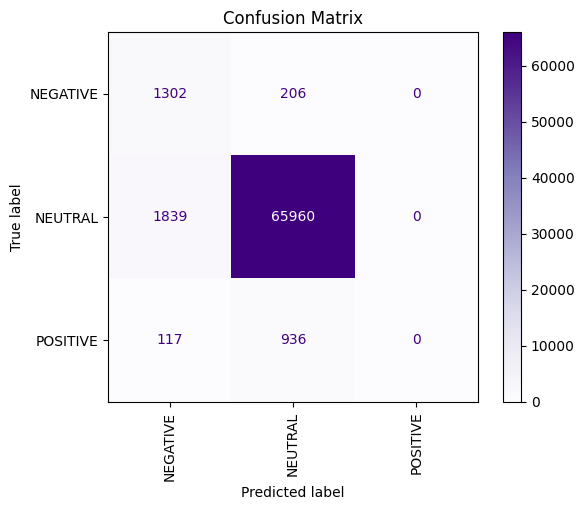

In [61]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

def evaluate_predictions(predictions, gold_labels, label_list):
    """
    Evaluate predictions against gold labels and print metrics.
    """
    predictions_flat = [label_list.index(label) for label in predictions]
    gold_labels_flat = [label_list.index(label) for label in gold_labels]

    accuracy = accuracy_score(gold_labels_flat, predictions_flat)
    report = classification_report(gold_labels_flat, predictions_flat, target_names=label_list, digits=4)

    cm = confusion_matrix(gold_labels_flat, predictions_flat, labels=list(range(len(label_list))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
   
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    disp.plot(cmap=plt.cm.Purples, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

evaluate_predictions(new_predictions, new_labels, label_list)


In [63]:
from transformers import set_seed

#put your seed
SEED = 95
set_seed(SEED)
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

In [65]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_training_dataset,
    eval_dataset=tokenized_test_dataset, #write test
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_1924/4074046499.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [67]:
trainer.train()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.079551,0.484234,0.511530,0.497508,0.954522
2,No log,0.095901,0.455020,0.507803,0.479965,0.950812
3,0.030400,0.111429,0.454299,0.507105,0.479252,0.951161


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEUTRAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maja/Documents/VU/thesis/venv

TrainOutput(global_step=687, training_loss=0.026291296818717946, metrics={'train_runtime': 551.0087, 'train_samples_per_second': 19.878, 'train_steps_per_second': 1.247, 'total_flos': 285344734224588.0, 'train_loss': 0.026291296818717946, 'epoch': 3.0})

In [70]:
trainer.save_model('BERT3_token_model')
trainer.tokenizer.save_pretrained('BERT3_token_model')

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('BERT3_token_model/tokenizer_config.json',
 'BERT3_token_model/special_tokens_map.json',
 'BERT3_token_model/vocab.txt',
 'BERT3_token_model/added_tokens.json',
 'BERT3_token_model/tokenizer.json')

In [72]:
model = AutoModelForTokenClassification.from_pretrained("BERT3_token_model")
tokenizer = AutoTokenizer.from_pretrained("BERT3_token_model")

In [74]:
trainer.evaluate()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEUTRAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.11142867803573608,
 'eval_precision': 0.45429883138564275,
 'eval_recall': 0.5071045888655952,
 'eval_f1': 0.4792515134837645,
 'eval_accuracy': 0.9511614776576868,
 'eval_runtime': 29.2832,
 'eval_samples_per_second': 130.587,
 'eval_steps_per_second': 8.162,
 'epoch': 3.0}

In [80]:
predictions, labels, _ = trainer.predict(tokenized_test_dataset) #data set
predictions = np.argmax(predictions, axis=2)

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEUTRAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWar

In [82]:
output_file = "predictions_BERT3.csv"
new_tokens, new_labels, new_predictions = map_predictions_to_words_and_save_to_file(predictions, labels, tokenized_test_dataset, output_file)

Results saved to predictions_BERT3.csv


Accuracy: 0.9578453666856168
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE     0.4172    0.8534    0.5604      1508
     NEUTRAL     0.9826    0.9750    0.9788     67799
    POSITIVE     0.0000    0.0000    0.0000      1053

    accuracy                         0.9578     70360
   macro avg     0.4666    0.6095    0.5131     70360
weighted avg     0.9558    0.9578    0.9552     70360



/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

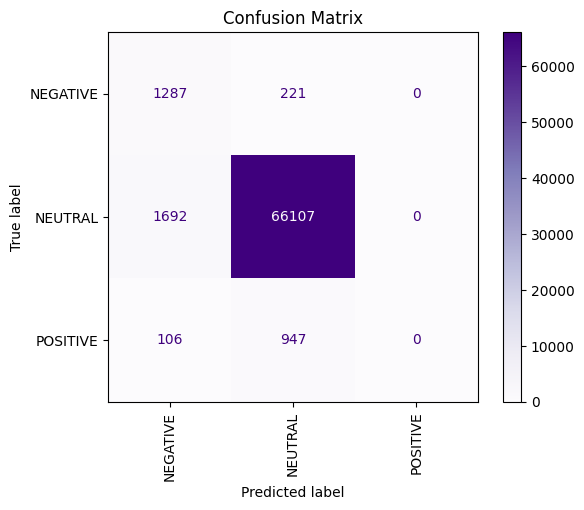

In [84]:
evaluate_predictions(new_predictions, new_labels, label_list)